# How To Search for QPOs with BayesPSD

This notebook is a demonstration for how to use the code in this package
to search for quasi-periodic oscillations (QPOs) in X-ray data of bursts.

This code requires
* python 2.7 or later (not really tested with python 3)
* numpy
* scipy
* matplotlib

Recommended
* emcee (https://github.com/dfm/emcee)
* acor (https://github.com/dfm/acor)
* statsmodels (https://github.com/statsmodels/statsmodels; only for using crazy minimization algorithms that don't return the inverse covariance)
* seaborn for making pretty plots (http://stanford.edu/~mwaskom/software/seaborn/)

## Basics

The module contains both the code to do Bayesian inference on bursty time series, as well 
as some basic class definitions that are useful for time series analysis in general, and for
*Fermi*/GBM data in particular.

Let's start with a simple time series in a data file. This is actually a magnetar bursts from 
a source called SGR J1550-5418, but that's not important right now. 
I've made things easy for you here: the data are individual photon events and energies only from 
the part of the observation where the burst was observed. We'll have a look at more complicated 
data and how to automate the steps outlined below later.

For now, let's import some code and load the time series.



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## this is just to make plots prettier
## comment out if you don't have seaborn
import seaborn as sns 
sns.set()
########################################

import numpy as np


**NOTE**: You need to have the directory where you saved the BayesPSD code in your `PYTHONPATH` variable for the following to work! If you haven't set your variable externally, you can do it in the following way:


In [3]:
import sys
sys.path.append("/Users/danielahuppenkothen/work/repositories/BayesPSD")

Be aware that you need to replace the directory structure with your own, and that you need to add the path to the directory in which the BayesPSD folder is located. In my case, that's in my `repositories` folder in my work directory on my home folder, but it will be different for you!
Also, when importing below, `bayespsd` needs to be written exactly as the name of the folder (it's case sensitive!). 

Now we can import functions and classes from that package:

In [4]:
from BayesPSD import Lightcurve, PowerSpectrum

The data are saved in a simple text file:

In [5]:
## the directory where we've stored the data
datadir = "../data/" 

data = np.loadtxt(datadir+"090122283_+071.87300_eventfile.dat")
print("Data shape : " + str(data.shape))

Data shape : (13001, 2)


The result is a numpy-array with 130001 rows and 2 columns. Each row is a photon, the first column contains the photon arrival times, the second column the energies.

For now, let's not care about the energies (don't worry, we'll get back to that later!).
Let's make a light curve and plot it:

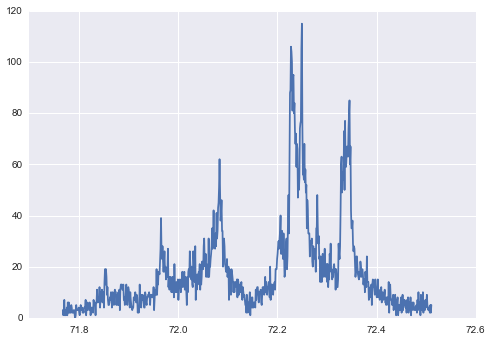

In [6]:
timestep = 0.001 ##the time resolution for the light curve
lc = Lightcurve(data[:,0], timestep=timestep)

plt.figure()
plt.plot(lc.time, lc.counts)

There you go, it's a burst. The class `Lightcurve` has several useful attributes. Have a look at the code if you're interested. It works both with time tagges arrival times (in which case it takes a value `timestep` for the output time resolution) or with counts, in which case you should use the keyword `times` for time bins and `counts` for the counts per bin.

The next step is to make a periodogram. This is easy if we already have a `Lightcurve` object.
Note that we'll use `loglog` for the figure rather than `plot`, because the spectrum is better plotted on a log-log scale.

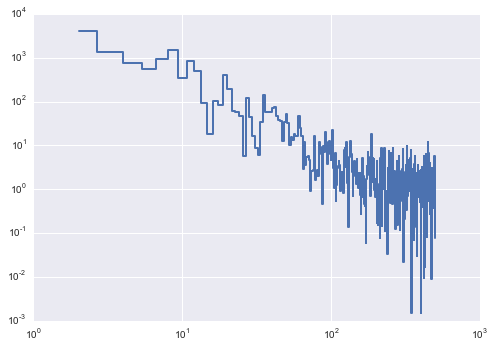

In [7]:
ps = PowerSpectrum(lc, norm="leahy")

plt.loglog(ps.freq[1:], ps.ps[1:], lw=2, linestyle="steps-mid")

The `PowerSpectrum` class comes with three normalizations built-in: `leahy` for the Leahy normalization, `rms` for a rms-normalized periodogram and `variance` for a periodogram that is normalized to the total variance.

For most purposes here, the Leahy normalization (default) is probably what you want, but the other options are there if you want them.

## ML/MAP Fitting

So far, we haven't actually done any analysis. Let's first talk about models.
All parametric models are saved in the model `parametricmodels.py`.

In [8]:
from BayesPSD import pl, bpl, const, qpo

We can now, for example, fit one of these models to the data.
This kind of fitting is implemented in the class `PerMaxLike`, which, despite its name
actually usually does maximum-a-posteriori estimates rather than maximum likelihood estimates.


In [9]:
from BayesPSD import PerMaxLike

psfit = PerMaxLike(ps, obs=True, fitmethod="bfgs")

`PerMaxLike` takes a `PowerSpectrum` object. The variable `obs` controls whether output plots and logs are produced (set True if you want those!) and `fitmethod` sets one of the optimization algorithms specified in scipy.optimize.
My recommendation is to set to `bfgs` unless you have a good reason not to.

In order to actually fit a model to the periodogram, we'll need to specify what model, and will also have to set starting guesses for the parameters. Note that the number of parameters. Look at the function definitions for details about the different models. In the case below, we'll use a simple power law model, which takes the power law index, the log(amplitude) and log(background).

The actual fitting is implemented in method `mlest`. For details on all parameters this method takes, see the documentation. Below are the most important ones. Again, we can set whether the code should produce plots and be verbose, and we can set whether the periodogram we use is the simple Fourier transform of a light curve (m=1) or whether it is the average of several periodograms (or frequency bins). 
If `map` is True, the code will produce the maximum-a-posteriori estimate, otherwise it'll return a Maximum Likelihood estimate.

In [10]:
## starting parameters
pars = [2,10,np.log(2.0)]

fitparams = psfit.mlest(pl, pars, obs=True, m=1, map=True)

Gradient and/or function calls not changing!
Approximating covariance from BFGS: 
Covariance (empirical): [[ 0.02036338  0.0781775   0.0117943 ]
 [ 0.0781775   0.31121761  0.041365  ]
 [ 0.0117943   0.041365    0.01405316]]
The best-fit model parameters plus errors are:
Parameter 0: 2.08723748958 +/- 0.142700328632
Parameter 1: 11.1100661977 +/- 0.557868814871
Parameter 2: 0.457427143928 +/- 0.118546023877
The Akaike Information Criterion of the power law model is: 887.00711241.
The figure-of-merit function for this model is: 359.736396168 and the fit for 368.0 dof is 0.977544554804.
Fitting statistics: 
 -- number of frequencies: 371
 -- Deviance [-2 log L] D = 1762.01422482
 -- Highest data/model outlier 2I/S = 13.5363506735
    at frequency f_max = 450.940860213
 -- Highest smoothed data/model outlier for smoothing factor [3] 2I/S = 7.5281022425
    at frequency f_max = 452.284946234
 -- Highest smoothed data/model outlier for smoothing factor [5] 2I/S = 5.91861983855
    at frequen

The fitting routine returns a dictionary with lots of interesting and useful information. Let's have a look at the dictionary keys:

In [11]:
print(fitparams.keys())

['maxind', 'smooth3', 'smooth5', 'merit', 'result', 'popt', 's11maxfreq', 'maxpow', 's5maxfreq', 's5max', 's3max', 's11max', 's3maxfreq', 'bindict', 'maxfreq', 'bic', 'sexp', 'smooth11', 'ssd', 'ksp', 'err', 'deviance', 'cov', 'dof', 'mfit', 'sobs', 'model', 'aic']


Here are the most interesting ones:

In [12]:
print("The best-fit parameters are " + str(fitparams["popt"]))
print("The covariance matrix for the parameters is: " + str(fitparams["cov"]))
print("The MAP estimate (or Maximum Likelihood estimate) is %.3f"%fitparams["result"])
print("The deviance (-2*log(maximum likelihood)) is %.3f"%fitparams["deviance"])
print("The Akaike Information Criterion is %.3f."%fitparams["aic"])
print("The Bayesian Information Criterion is %.3f."%fitparams["bic"])

The best-fit parameters are [  2.08723749  11.1100662    0.45742714]
The covariance matrix for the parameters is: [[ 0.02036338  0.0781775   0.0117943 ]
 [ 0.0781775   0.31121761  0.041365  ]
 [ 0.0117943   0.041365    0.01405316]]
The MAP estimate (or Maximum Likelihood estimate) is 881.007
The deviance (-2*log(maximum likelihood)) is 1762.014
The Akaike Information Criterion is 887.007.
The Bayesian Information Criterion is 1994.007.


A side note: likelihoods, priors and posteriors are implemented in `Posterior` and its subclasses. 
Currently (fairly uninformative) priors are hard-coded. If you need different priors, my suggestion is to fork the repository and implement them in a separate branch. Or you could subclass Posterior to make your own.

## Bayesian QPO Detection

So now comes the fun bit: we can do the actual QPO search! Most of that is implemented in the class `Bayes`. Its constructor takes a `PowerSpectrum` object and various parameters: 

In [13]:
from BayesPSD import Bayes

bb = Bayes(ps, namestr='demo', plot=True, m=1)

The variable `namestr` allows you do set a string identifier for all output plots and text files. This is especially useful if you run many bursts and need to save each in its own separate file.

The variable `plot` controls whether the code produces output plots for diagnostic purposes. This is usually a useful feature to leave on. 

Finally, the periodogram we just produced above is a simple Fourier transform of a single light curve. However, in some applications, you might want to average periodograms or frequency bins, in which case the statistical distributions used in the likelihood need to change. Set `m` to the number of periodograms or frequency bins averaged.


There will be two steps: First, we need to make some statement about what kind of model to use for the broadband noise (that annoying lower-law-shaped component in the plot above). In the second step we'll use that broadband noise model to infer the presence of a QPO.

Note that unless you care in detail whether you are using the parsimonious model, you can skip step (1) and just use a more complex model. We'll demonstrate the functionality here anyway.

In [14]:
## the two noise models
model1 = pl
model2 = bpl

## input parameters for both
par1 = [1.,4.,np.log(2.0)]
par2 = [1.,3.,2.,3., np.log(2.0)]

## parameters for the MCMC run
nchain = 200 ## number of emcee walkers
niter = 200 ## number of iterations per chain
nsim = 100 ## number of simulations to run

psfit, fakeper, summary = bb.choose_noise_model(model1, par1,
                                               model2, par2, 
                                               fitmethod="bfgs",
                                               nchain = nchain, niter = niter,
                                               nsim = nsim, writefile=True)


Approximating covariance from BFGS: 
Covariance (empirical): [[ 0.03253482  0.13130155  0.01009341]
 [ 0.13130155  0.54188035  0.03744738]
 [ 0.01009341  0.03744738  0.00901978]]
The best-fit model parameters plus errors are:
Parameter 0: 2.08723754207 +/- 0.180374112506
Parameter 1: 11.1100663176 +/- 0.736125223821
Parameter 2: 0.457427265489 +/- 0.0949725030814
The Akaike Information Criterion of the power law model is: 887.00711241.
The figure-of-merit function for this model is: 359.736373665 and the fit for 368.0 dof is 0.977544493654.
Fitting statistics: 
 -- number of frequencies: 371
 -- Deviance [-2 log L] D = 1762.01422482
 -- Highest data/model outlier 2I/S = 13.5363495029
    at frequency f_max = 450.940860213
 -- Highest smoothed data/model outlier for smoothing factor [3] 2I/S = 7.52810159015
    at frequency f_max = 452.284946234
 -- Highest smoothed data/model outlier for smoothing factor [5] 2I/S = 5.91861932672
    at frequency f_max = 450.940860213
 -- Highest smooth

Running this code will print a lot of diagnostics on the screen (and also to a log file): the results of the MAP fitting for both models, mean, standard deviations and quantiles for the three parameters and more.

It also returns a bunch of objects useful for further analysis:
* `psfit` contains a `PerMaxLike` object. In its attributes `plfit` and `bplfit` it contains summary dictionaries for the power law and bent power law models, respectively, with results from the initial MAP fit on the data, as we've created when we did the fitting by hand above
* `fakeper` contains the list of all fake periodograms created during the simulation stage
* `summary` is a dictionary with the results printed at the very end of the analysis.

You should also have a couple of plots, all starting with whatever string you gave it for variable `namestr` above (in my case "demo"):
* `demo_ps_fit.png` shows the periodogram and the MAP fits for the two broadband noise models
* `demo_scatter.png` shows a triangle plot of the posterior distributions of the parameters for model 1. This can quite useful for diagnosing how well behaved the posterior distribution is, and whether there are correlations between parameters
* `demo_quantiles.png` shows the 80% quantiles for all parameters and all Markov chains/walkers. This plot is more useful for Metropolis-Hastings than it is for emcee.
* `demo_rhat.png` plots $\hat{R}$ for all parameters in model 1. $\hat{R}$ is another quantity for diagnosing convergence. It compares the variance within Markov chains to the variance between Markov chains. In general, well-mixed chains will have $\hat{R} \approx 1$. If it's much larger than 1.2, I'd start worrying a bit (and perhaps either increase the number of chains (in emcee) or the number of samples (in both MH and emcee). 
* `demo_lrt.png` shows a histogram of the posterior distribution of the likelihood ratios constructed from model 1, together with the observed value.


In the very end, the code will print to the screen a bunch of posterior predictive p-values; the most important one here is the one for the likelihood ratio. What we've done in this part of the analysis is essentially this:
1. compute MAP estimates for both models chosen to compare for the data
2. compute the likelihood ratio of both models for the data
3. pick parameter sets from the posterior PDF for model 1 via MCMC
4. from `nsim` randomly picked parameter sets, simulate a periodogram for each
5. fit all `nsim` fake periodograms with both models, compute the likelihood ratio for each
6. build a posterior distribution for the likelihood ratio of both models under the null hypothesis that model 1 is actually representative of the data
7. compute how many samples in the distribution lie above the value computed for the data and divide by the total number of samples for the p-value.

This number essentially tells you what likelihood ratio would be expected if the data were generated from model 1. 
If the observed likelihood ratio is an outlier with respect to the derived distribution, this could be taken as an indicator that the data are unlikely to be generated. However, it is explicitly **not** an indicator that the data were instead generated from model 2. Strictly speaking, this conclusion is not supported by the test we've done, although we will use it in a way that might seem to imply it. 
There could be other reasons for why the likelihood ratio we have observed is an outlier with respect to the distributions derived from the posterior sample: we could have simply picked two models that don't particularly describe the data very well, so that neither is an appropriate model for the data. Or perhaps our statistical distributions aren't quite what we expected them to be (which can be the case for dead time), which can also have an effect. 

In conclusion, be wary of any results you derive from the analysis above. Model comparison is always tricky, but for QPO detection, having a model that is a reasonable approximation of the broadband shape of the periodogram is good enough. So you can rightfully skip this step and just use the more complex model (usually a bent power law) and get away with it.

Now that we've got that out of the way, let's do the actual QPO fitting. There's a method for that, too!


In [15]:
noise_model = bpl
par = [1,3,2,3,np.log(2.0)]
nchain = 200
niter = 1000
nsim = 1000

results = bb.find_periodicity(noise_model, par, 
                             nchain=nchain, niter=niter, nsim=nsim)

Gradient and/or function calls not changing!
Approximating covariance from BFGS: 
Covariance (empirical): [[ 0.38054755  0.23509512  0.68112036  1.2383846  -0.01812769]
 [ 0.23509512  0.31074405  0.23346897  0.53388234 -0.02790734]
 [ 0.68112036  0.23346897  1.52872923  2.53538571 -0.00838119]
 [ 1.2383846   0.53388234  2.53538571  4.39645654 -0.03488924]
 [-0.01812769 -0.02790734 -0.00838119 -0.03488924  0.00595677]]
The best-fit model parameters plus errors are:
Parameter 0: 1.18492034413 +/- 0.6168853646
Parameter 1: 9.05996213796 +/- 0.557444211711
Parameter 2: 2.87967378908 +/- 1.23641790086
Parameter 3: 3.32810167723 +/- 2.09677288761
Parameter 4: 0.610094126788 +/- 0.077180137587
The Akaike Information Criterion of the power law model is: 888.151939903.
The figure-of-merit function for this model is: 358.350560945 and the fit for 366.0 dof is 0.979099893291.
Fitting statistics: 
 -- number of frequencies: 371
 -- Deviance [-2 log L] D = 1756.30387981
 -- Highest data/model outli

Much like the `choose_noise_model` method above, this code prints a bunch of useful information to the screen (and a log file) and makes some figures. 

Most importantly, it prints a bunch of blocks that start with "The posterior p-value for the maximum residual power [...]". Each of these blocks details the results for the binned periodogram at the specified frequency. 
The rationale behind this is that QPOs can be narrow or broad: a single QPO might be spread out over several frequency bins, or it might be so coherent it is mostly concentrated in one bin (although even then, sampling will usually cause it to be spread over two adjacent bins). So in searching for QPOs in various frequency bins, we do not risk missing signals that may be broader than the native frequency resolution. 
Of course, the fact that we've searched more than one periodgram needs to be taken into account when computing the number of trials: while strictly speaking, the binned periodograms are not statistically independent of each other, the conservative assumption to make is that they are, and multiply the number of trials by 7 (the number of frequency bins searched).

Note that after that initial statement, which includes the frequency bin width as well as the posterior p-value (uncorrected for the number of trials in general, including the frequency *binning*, but it does take into account the fact that we searched many frequencies per periodogram), it also prints $T_{R,j} = \max_j{2I_j/S_j}$, where $I_j$ is the power at frequency $j$ and $S_j$ is the model power spectrum at frequency $j$. 
Finally, it also prints the upper limit (actually, strictly speaking we show the sensitivity) the fractional rms amplitude that we could have detected at a few useful frequencies. Note that this sensitivity depends on *frequency*, because the broadband noise depends on frequency and changes the sensitivity at various frequencies. 

Again, this method produces two different plots:
* `demo_scatter.png`, which is the same plot as produced during the model comparison step, but for whatever model was used for finding QPOs
* `demo_maxpow.png` shows the posterior distribution for four different frequency bins. Actually, what it shows are the data at the native time resolution as well as for three different Wiener filter smoothed periodograms (which I thought might be useful at some point, but don't really use in practice). 

Usually, when searching for QPOs, I will do the search with `nsim=1000` and derive p-values up to $10^{-3}$ to conserve computation. Then I will pick all light curves that have a p-value (corrected for number of trials) of $<10^{-2}$ in at least two or more frequency bins, and re-run those with however many simulations are required to be confident the detection is real.
For example, if I had 250 bursts, each of which I decided to run once (for the full light curve), and decided that I'll report any signal that has a posterior predictive p-value, corrected for the number of trials, of $10^{-2}$, then I would have to re-run those bursts that have candidate signals with at least $\frac{10^{-2}}{250 \times 7 \times 100}$ simulations, $250$ for the number of bursts, $7$ for the number of frequency bins, and then another factor of $100$ to make sure I have enough simulations to actually trace out the tail of the distribution sufficiently. This can be a very large number, in which case memory can become an issue. If it does, move to a bigger computer, or let me know!


# Running Several Bursts at Once

The code above will work well for the occasional burst, but for large data sets, you'd want to automate it. Of course, you could do that yourself, but for various useful corner cases, there's some code set up that will make things simple.

Especially for *Fermi*/GBM data, the following code will be useful. 
Below will be two cases:
1. Data that comes out of my *Fermi*/GBM processing pipeline
2. Data that is stored in an ascii text file (the file format either needs to match the one below, or you'll need to change the code to something that matches your file name structure). 

At the heart of this is a set of classes called `Burst` and `GBMBurst` that define useful methods for bursts (and can easily be extended). In particular, class `Burst` has a method that runs the Bayesian QPO search automatically.

What you're going to need for the following analysis are
1. the data files with the TTE data; this must contain in the first column photon arrival times, in the second (optionally) photon energies or channels
2. a file that has at least three columns:
    * the identifier for the observations (e.g. the *Fermi*/GBM trigger ID)
    * the burst start times in the same format as the TTE photon arrival times (seconds since trigger works pretty well)
    * the burst duration in seconds 

## Using the Burst class to simplify things

For a single light curve, like the one used above, we can make a `GBMBurst` object as done below. When creating this object, it will automatically create a light curve and periodogram up to whatever Nyquist frequency is specified. It is also possible to specify the normalization of the periodogram, the fluence of the burst and the peak energy for various purposes.


In [16]:
from BayesPSD import GBMBurst

## load data
data = np.loadtxt('../data/090122283_+071.87300_eventfile.dat')
times = data[:,0] ## photon arrival times
events = data[:,1] ## photon energies

## we can get ObsID and start time from the file name in this case
## for others, we might need to read it from a file

#split filename into components and get ObsID and start time
fsplit = "090122283_+071.87300_eventfile.dat".split("_")
print(fsplit)
bid = fsplit[0] ##ObsID
bst = np.float(fsplit[1]) ## burst start time

## let's pretend we know the burst duration
blen = 0.1

## we're going to search between 8 and 200 keV
energies = [8.0, 200.0]

## We want to search up to 4096 Hz:
fnyquist = 4096.

## How much of the burst duration do we want to 
## add on either side of the burst?
addfrac = 0.2

## create GBMBurst object; note the confusing syntax:
## - energies contains energy ranges to use
## - events actually contains the list of photon energies
burst = GBMBurst(bid=bid, bstart=bst, blength=blen,
                energies=energies, photons=times, events=events, 
                instrument="gbm", fnyquist=fnyquist, addfrac=addfrac)


['090122283', '+071.87300', 'eventfile.dat']


Note that for convenience, the code adds 20% of the burst duration on either side of the light curve, to make sure the light curve goes back to the background on either side (anything can cause funny effects in the Fourier transform!). 

We can now look at the light curve:

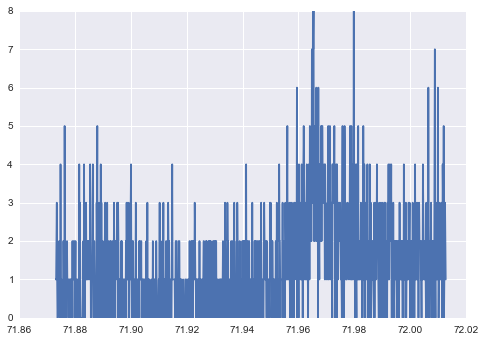

In [17]:
lc = burst.lc

plt.figure()
plt.plot(lc.time, lc.counts)

Or the periodogram:

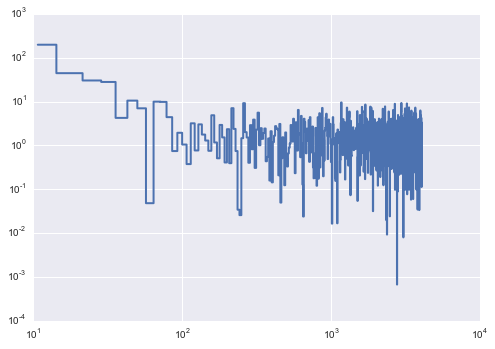

In [18]:
ps = burst.ps

plt.figure()
plt.loglog(ps.freq[1:], ps.ps[1:], lw=2, linestyle="steps-mid")

Or we can run the entire Bayesian QPO search:

In [19]:
namestr = "%s_%.3f_test"%(bid, bst) ## a string identifier for output files
nchain = 500 ## number of emcee walkers
niter = 100 ## number of iterations in the Markov chain
nsim = 100 ## number of simulations

m = 1 ## periodogram not averaged
fitmethod = "bfgs" ## use BFGS for optimization

burst.bayesian_analysis(namestr = namestr,
                       nchain = nchain,
                       niter = niter,
                       nsim = nsim,
                       m = 1, fitmethod = fitmethod)



Approximating covariance from BFGS: 
Covariance (empirical): [[  4.63587196e-04  -6.18747667e-04   7.70553015e-07]
 [ -6.18747667e-04   1.58317577e-02   1.04012294e-03]
 [  7.70553015e-07   1.04012294e-03   2.39010755e-04]]
The best-fit model parameters plus errors are:
Parameter 0: 2.4895265847 +/- 0.0215310751265
Parameter 1: 11.335737436 +/- 0.125824312696
Parameter 2: 0.658734924935 +/- 0.015459972663
The Akaike Information Criterion of the power law model is: 980.029232656.
The figure-of-merit function for this model is: 493.754632446 and the fit for 569.0 dof is 0.867758580749.
Fitting statistics: 
 -- number of frequencies: 572
 -- Deviance [-2 log L] D = 1948.05846531
 -- Highest data/model outlier 2I/S = 9.8405327097
    at frequency f_max = 1175.90226876
 -- Highest smoothed data/model outlier for smoothing factor [3] 2I/S = 6.3619557368
    at frequency f_max = 2970.13612565
 -- Highest smoothed data/model outlier for smoothing factor [5] 2I/S = 4.90526698463
    at frequenc

And then it goes through the entire analysis above.

## Running Many Bursts

I've provided you with two files:
* `sgr1550_burstdata.dat` has some burst IDs, start times and durations as specified above
* `090122037a_tte_combined.dat` contains the photon arrival times and energies needed to run the bursts in the file above.

The following defines some (simple) code that will read in `sgr1550_burstdata.dat`.

In [19]:
def read_burstdata(filename, datadir="./"):
    """
    Run Bayesian QPO search on all bursts in file filename. 
    
    Parameters
    ----------
    filename: string
        Name of a file with minimal burst data. Needs to have columns:
        1. ObsID
        2. MET trigger time
        3. Seconds since trigger
        4. Burst duration in seconds
        Note that this is the way my file is currently set up. You can change 
        this by changing the indices of the columns read out below.
    
    datadir: string
        Directory where the data (including the file in filename) is located.
    """
    
    ## read in data
    ## type needs to be string, otherwise code fails on ObsID column, 
    ## which doesn't purely consist of numbers
    data  = np.loadtxt(datadir+filename, dtype=np.string_)
    
    ## ObsIDs are in first column, need to remain string
    obsids = data[:,0]
    
    ## trigger time is in second column, should be float
    trigtime = data[:,1].astype("float64")
    
    ## start time in seconds since trigger is in third column,
    ## should be float
    bstart = data[:,2].astype("float64")
    
    ## burst duration in seconds is in fourth column,
    ## should be float
    blength = data[:,3].astype("float64")
    
    
    return obsids, trigtime, bstart, blength
    

Now run the function above on the example file:

In [20]:
## now run the function above on the example file
obsids, trigtime, bstart, blength = read_burstdata("sgr1550_burstdata.dat", datadir="../data/")

Next, we'll need to load the data, snip out the parts of the light curve that have bursts and make a GBMBurst object, so that we can then easily run the QPO search. 

We'll loop over the ObsIDs first, because if there is more than one burst in a single observation, it makes no sense reading in the data several times!
Then we'll find all bursts that have this ObsIDs, and for those bursts, we make GBMBurst objects with the data.

In [21]:
## empty list to store all burst objects in
allbursts = []

## which energy range do we want to run over?
energies = [8.,200.]

## what's the Nyquist frequency supposed to be?
## This depends on the time resolution of your instrument
## and the frequencies where you expect QPOs to appear
fnyquist = 4096.

## get the unique set of ObsIDs
obsid_set = np.unique(obsids)

## loop over all ObsIDs
for o in obsid_set:
    ## this filename structure should reflect what your data files look like
    ## mine all look like ObsID_tte_combined.dat
    ## and contain TTE data (seconds since trigger) and photon energies
    datafile = datadir+"%s_tte_combined.dat"%o
    data = np.loadtxt(datafile)
    times = data[:,0]
    events = data[:,1]
    
    ## find all bursts in this observation
    bst = bstart[obsids == o]
    blen = blength[obsids == o]
    ttrig = trigtime[obsids == o]
    print(len(bst))
    
    ## loop over all bursts
    for s,l in zip(bst, blen):
        burst = GBMBurst(bid=o, bstart=s, blength=l,
                        energies=energies, photons=times, events=events, 
                        instrument="gbm", fnyquist=fnyquist)

        allbursts.append(burst)


8


Now that we have all bursts in a list, running the Bayesian QPO search is easy:

In [26]:

nchain = 500 ## number of chains
niter = 200 ## number of iterations per chain
nsim = 100 ## number of simulations, small to make it run fast for demo purposes
fitmethod = "bfgs" ## scipy.optimize minimization algorithm

## we'll just run 1 burst for brevity; delete [:1] if you want to run 
## on all bursts
for burst in allbursts[:1]:
    ## identifier for the output
    namestr = "%s_%.3f"%(burst.bid, burst.blen)
    
    ## run Bayesian analysis
    burst.bayesian_analysis(namestr = namestr,
                       nchain = nchain,
                       niter = niter,
                       nsim = nsim,
                       m = 1, fitmethod = fitmethod)




Approximating covariance from BFGS: 
Covariance (empirical): [[ 0.21975713  0.89956171  0.01743839]
 [ 0.89956171  3.89602763  0.0628207 ]
 [ 0.01743839  0.0628207   0.00605623]]
The best-fit model parameters plus errors are:
Parameter 0: 1.56734124133 +/- 0.468782602388
Parameter 1: 8.16380494438 +/- 1.97383576589
Parameter 2: 0.609911688411 +/- 0.0778218149677
The Akaike Information Criterion of the power law model is: 429.807823525.
The figure-of-merit function for this model is: 208.647616242 and the fit for 248.0 dof is 0.841321033233.
Fitting statistics: 
 -- number of frequencies: 251
 -- Deviance [-2 log L] D = 847.615647051
 -- Highest data/model outlier 2I/S = 9.90945355874
    at frequency f_max = 3080.12698413
 -- Highest smoothed data/model outlier for smoothing factor [3] 2I/S = 8.19938171276
    at frequency f_max = 3080.12698413
 -- Highest smoothed data/model outlier for smoothing factor [5] 2I/S = 6.55444979164
    at frequency f_max = 3080.12698413
 -- Highest smooth

And we're done with the basic QPO search for burst light curves!
For convenience, I've made a script that takes the code below and allows you to run it directly from the command line:

    `shell> python run_bursts.py -f "sgr1550_burstdata.dat" -d "../data/"`